# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur agrégé au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# TD4 - Régression linéaire

Ce TD concerne la régression linéaire (Chapitre 2 du cours). À la fin de ce TD, vous devriez être avoir été en mesure de :
- Choisir un modèle sur la base de l'estimation ou de la prédiction.
- Vérifier pour la présence de multicolinéarité.
- Transformer les variables pour modéliser des relations non-linéaires.


## Contexte : Poids des poissons

Le fichier *fishweights.csv* contient les caractéristiques de 158 poissons péchés dans le lac Laengelmavesi en Finlande. Nous étudierons le poids (Weight en grammes) des poissons en fonction de variables explicatives suivantes :
- l'espèce de poisson (species) ;
- la longueur standard (StandardLength) ;
- la longeur non standard  (NonStandardLength) ;
- la longueur totale (TotalLength) ;
- la hauteur (Height) ;
- la largeur (Width).


          ___/////___                  _
         /           \    ___          |
       /\             \_ /  /          H
     <   )            __)  \           |
       \/_\\_________/   \__\          _

     |------- SL -------|
     |------- NSL ---------|
     |------- TL ------------|

In [190]:
using CSV 
using DataFrames
using Distributions
using Gadfly
using LinearAlgebra
using Statistics
using Random

## Chargement des données

In [2]:
data = CSV.read("fishweights.csv", DataFrame)
first(data,10)

,Species,Weight,StandardLength,NonStandardLength,TotalLength,Height,Width
,String15,Float64,Float64,Float64,Float64,Float64,Float64
1,Brème,242.0,23.2,25.4,30.0,11.5,4.0
2,Brème,290.0,24.0,26.3,31.2,12.5,4.3
3,Brème,340.0,23.9,26.5,31.1,12.4,4.7
4,Brème,363.0,26.3,29.0,33.5,12.7,4.5
5,Brème,430.0,26.5,29.0,34.0,12.4,5.1
6,Brème,450.0,26.8,29.7,34.7,13.6,4.9
7,Brème,500.0,26.8,29.7,34.5,14.2,5.3
8,Brème,390.0,27.6,30.0,35.0,12.7,4.7
9,Brème,450.0,27.6,30.0,35.1,14.0,4.8


# Exercice 1 - Analyse exploratoire

## a) Illustrez les poids en fonction des espèces de poisson

**Note :** Avec Gadfly, la variable *x* peut être une variable catégorielle.

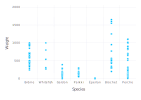

In [4]:
plot(data, x=:Species, y=:Weight)

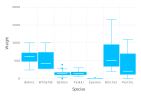

In [5]:
plot(data, x=:Species, y=:Weight, Geom.boxplot)

## b) Illustrez les poids en fonction de la longeur standard et des espèces.

**Suggestion :** Utilisez l'option *color* de Gadfly pour distinguer les différentes espèces.

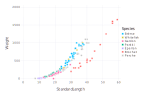

In [6]:
plot(data, x=:StandardLength, y=:Weight, color=:Species)

## c) Calculez le poids moyen pour chaque espèce ainsi que le nombre d'observations pour chaque espèce.

Les fonctions `combine()` et `groupby()` permettent d'effectuer rapidement ces tâches. Puisqu'elles ne sont pas intuitives, je vous donne d'emblée la réponse. C'est une combinaison de commandes qui pourra vous être utile dans tout le cours.

In [7]:
df = combine(groupby(data, :Species), :Weight => mean => :Weight, :Weight => length => :n)

,Species,Weight,n
,String15,Float64,Int64
1,Brème,626.0,34
2,Whitefish,531.0,6
3,Gardon,152.05,20
4,Parkki,154.818,11
5,Éperlan,11.1786,14
6,Brochet,718.706,17
7,Perche,382.239,56


# Exercice 2 - Ajustement *vs* prédiction

Dans cet excercice, on considère le **poids** des éperlans en fonction de la **longueur standard**. On utilisera un ensemble d'entraînement ainsi qu'un ensemble de validation pour évaluer l'erreur de prédiction sur des données non utilisées pour l'estimation des paramètres.

In [8]:
"""
    construct_structure(x::Vector{<:Real}, order::Int)

Construction de la matrice de structure du modèle polynomial d'ordre `order` à partir du vecteur `x`.
"""
function construct_structure(x::Vector{<:Real}, order::Int)
    
    X = Array{Float64}(undef, length(x), order+1)
    
    for p in 0:order
       X[:,p+1] = x.^p 
    end
    
    return X
    
end

construct_structure

## a) Construction de l'ensemble d'entraînement et de validation pour les éperlans

In [191]:
pct = 0.7

start_train = 0
end_train = floor(14 * pct)


# eperlans = data[!, data[!, :Species == "Éperlan"]]
eperlans = filter(row -> (row.Species == "Éperlan"),  data)
eperlans

eperlans = eperlans[shuffle(axes(eperlans, 1)), :]

function train_test_split(x, pct::Int)
    n, p = size(x)
    limit = Int(floor(n * pct/100))
    train = x[1:limit, :]
    test = x[limit+1:n, :]
    return train, test 
end

train, test = train_test_split(eperlans, 70)

# size(eperlans)

(9×7 DataFrame
 Row │ Species   Weight   StandardLength  NonStandardLength  TotalLength  Heig ⋯
     │ String15  Float64  Float64         Float64            Float64      Floa ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ Éperlan       8.7            10.8               11.3         12.6       ⋯
   2 │ Éperlan       9.7            10.4               11.0         12.0
   3 │ Éperlan       9.9            11.3               11.8         13.1
   4 │ Éperlan      12.2            12.1               13.0         13.8
   5 │ Éperlan      10.0            11.3               11.8         13.1       ⋯
   6 │ Éperlan      19.7            13.2               14.3         15.2
   7 │ Éperlan       7.5            10.0               10.5         11.6
   8 │ Éperlan       6.7             9.3                9.8         10.8
   9 │ Éperlan       9.8            10.7               11.2         12.4       ⋯
                                                             

## b) Modèle linéaire

1. Estimez la droite de régression avec les données de l'ensemble d'entraînement.
2. Tracez la droite de régression ainsi que les points de l'ensemble d'entraînement.
3. Ajoutez les points de validation sur le graphique avec une autre couleur.

**Suggestion :** Utilisez la fonction `layer()` de Gadfly pour ajouter plusieurs couches à un graphique.

In [192]:
X_train = Matrix(hcat(ones(size(train)[1]), train[:, :StandardLength]))
y_train = train[:, :Weight]

X_test = Matrix(hcat(ones(size(test)[1]), test[:, :StandardLength]))
y_test = test[:, :Weight]

5-element Vector{Float64}:
 13.4
  7.0
 12.2
  9.8
 19.9

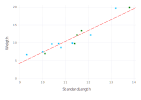

In [193]:
w = X_train\y_train
plot(
    layer(x=X_train[:,2], y=y_train, Geom.point, 
        intercept = [w[1]], slope = [w[2]], Geom.abline(color="red", style=:dash)),
    layer(x=X_test[:,2], y=y_test, Geom.point, color=[colorant"green"]), 
    Guide.xlabel("StandardLength"),
    Guide.ylabel("Weigth")
)

## c) Modèle cubique

1. Estimez les paramètres du modèle cubique en utilisant les données de l'ensemble d'entraînement.
2. Tracez la courbe donnée par le modèle ainsi que les points de l'ensemble d'entraînement.
3. Ajoutez les points de validation sur le graphique avec une autre couleur.

**Suggestion :** Utilisez la fonction `construct_structure()` fournie pour construire la matrice de structure pour le modèle cubique avec `order=3`.

In [194]:
X_train_3 = construct_structure(X_train[:, 2], 3)
X_test_3  = construct_structure(X_test[:, 2], 3)

5×4 Matrix{Float64}:
 1.0  11.7  136.89  1601.61
 1.0  10.1  102.01  1030.3
 1.0  11.5  132.25  1520.88
 1.0  11.4  129.96  1481.54
 1.0  13.8  190.44  2628.07

In [195]:
function polynom(x, w)
    y = 0
    order = length(w)
    for i in 1:order
        y += x^(i-1) * w[i]
    end
    return y
end

polynom (generic function with 2 methods)

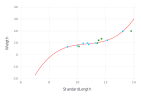

In [196]:
w_3 = X_train_3\y_train

plot(
    layer(x=X_train_3[:,2], y=y_train, Geom.point),
    layer(x=X_test_3[:,2], y=y_test, Geom.point, color=[colorant"green"]), 
    layer(x -> polynom(x, w_3), 7, 14, color=[colorant"red"]),
    Guide.xlabel("StandardLength"),
    Guide.ylabel("Weigth")
)

## d) Modèle d'ordre 6

1. Estimez les paramètres du modèle d'ordre 6 en utilisant les données de l'ensemble d'entraînement.
2. Tracez la courbe donnée par le modèle ainsi que les points de l'ensemble d'entraînement.
3. Ajoutez les points de validation sur le graphique avec une autre couleur.

**Suggestion :** Utilisez la fonction `construct_structure()` fournie pour construire la matrice de structure pour le modèle cubique avec `order=6`.

In [197]:
X_train_6 = construct_structure(X_train[:, 2], 6)
X_test_6  = construct_structure(X_test[:, 2], 6)

5×7 Matrix{Float64}:
 1.0  11.7  136.89  1601.61  18738.9       2.19245e5  2.56516e6
 1.0  10.1  102.01  1030.3   10406.0  105101.0        1.06152e6
 1.0  11.5  132.25  1520.88  17490.1       2.01136e5  2.31306e6
 1.0  11.4  129.96  1481.54  16889.6       1.92541e5  2.19497e6
 1.0  13.8  190.44  2628.07  36267.4  500490.0        6.90676e6

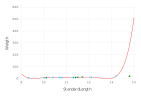

In [201]:
w_6 = X_train_6\y_train

plot(
    layer(x=X_train_6[:,2], y=y_train, Geom.point),
    layer(x=X_test_6[:,2], y=y_test, Geom.point, color=[colorant"green"]), 
    layer(x -> polynom(x, w_6, 6), 9, 14, color=[colorant"red"]),
    Guide.xlabel("StandardLength"),
    Guide.ylabel("Weigth")
)

## e) Calcul de la qualité d'ajustement et de l'erreur de prédiction

Pour les modèles d'ordre 0 à 6, calculez 
- le coefficient de détermination
- le coefficient de détermination ajusté
- l'erreur quadratique moyenne (MSE) sur l'échantillon de validation.

**Suggestion :** Ajoutez une ligne au tableau `df` proposé pour chacun des ordre de modèle avec la fonction `push!()`.


In [199]:
for p in 0:6
    X_train_p = construct_structure(X_train[:, 2], p)
    X_test_p = construct_structure(X_test[:, 2], p)
    w_p = X_train_p\y_train

    ȳ = mean(y_train)
    ŷ = X_train_p*w_p

    e = y_train-ŷ

    SST = sum( (y_train .- ȳ).^2 )
    SSR = sum( (ŷ .- ȳ).^2 )
    SSE = sum(e.^2)
    R² = SSR/SST
    n = size(y)[1]
    RCorrected = 1 - (SSE/(n-p-1)) / (SST/(n-1))
    println("## Polynome(",p,") ##")
    println("   R²  = ", R²) 
    println("   R²c = ", RCorrected) 
    
    y_predict = X_test_p * w_p
    MSE = mean((y_test-y_predict).^2)
    println("   MSE= ", MSE) 
    
    println()
end

## Polynome(0) ##
   R²  = 2.449455976190825e-31
   R²c = 1.1102230246251565e-16
   MSE= 22.611777777777778

## Polynome(1) ##
   R²  = 0.8478568902815055
   R²c = 0.8261221603217185
   MSE= 1.1110904962977615

## Polynome(2) ##
   R²  = 0.9502543730384061
   R²c = 0.9336724973845454
   MSE= 3.1144213206608633

## Polynome(3) ##
   R²  = 0.9817324337630722
   R²c = 0.9707718940208417
   MSE= 12.861535129704105

## Polynome(4) ##
   R²  = 0.9823048875148553
   R²c = 0.964609775029592
   MSE= 17.50364537728682

## Polynome(5) ##
   R²  = 0.987379748971689
   R²c = 0.9663459973408475
   MSE= 23.71343581531747

## Polynome(6) ##
   R²  = 0.9965211590271986
   R²c = 0.986084642098846
   MSE= 13774.934544862539



## f) Sélection du meilleur modèle

Selon vous, quel est le meilleur modèle ?

# Exercice 3 - Poids des perches

Dans cet exercice, on étudie la présence de multicolinéarité dans les variables explicatives pour les perches.

In [202]:
perche = filter(row -> row.Species == "Perche", data)
n = size(perche,1)
first(perche, 10)

,Species,Weight,StandardLength,NonStandardLength,TotalLength,Height,Width
,String15,Float64,Float64,Float64,Float64,Float64,Float64
1,Perche,5.9,7.5,8.4,8.8,2.1,1.4
2,Perche,32.0,12.5,13.7,14.7,3.5,2.0
3,Perche,40.0,13.8,15.0,16.0,3.8,2.4
4,Perche,51.5,15.0,16.2,17.2,4.6,2.6
5,Perche,70.0,15.7,17.4,18.5,4.6,2.9
6,Perche,100.0,16.2,18.0,19.2,5.2,3.3
7,Perche,78.0,16.8,18.7,19.4,5.2,3.1
8,Perche,80.0,17.2,19.0,20.2,5.6,3.1
9,Perche,85.0,17.8,19.6,20.8,5.1,3.0


In [210]:
last(perche,1)

,Species,Weight,StandardLength,NonStandardLength,TotalLength,Height,Width
,String15,Float64,Float64,Float64,Float64,Float64,Float64
1,Perche,1000.0,41.1,44.0,46.6,12.5,7.6


## a) Détection de la multicolinéarité.

Calculez le facteur d'inflation de la variance VIF pour les variables explicatives de la perche. Déterminez s'il y a multicolinéarité.

In [255]:
for i in 2:size(perche)[2]
    X = Matrix(hcat(perche[:, 2:i-1], perche[:, i+1:end]))
    X = Matrix(hcat(ones(size(perche)[1]), X))
    y = perche[:, i]
    b = X \ y
    
    ȳ = mean(y)
    ŷ = X*b
    
    e = y-ŷ
    
    SST = sum( (y .- ȳ).^2 )
    SSR = sum( (ŷ .- ȳ).^2 )
    SSE = sum(e.^2)
    R² = 1 - SSE/SST
    VIF = 1 / (1 - R²)
    println("Column:", i, "   VIF = ", VIF)
end

Column:2   VIF = 17.39595983733098
Column:3   VIF = 1780.085170939513
Column:4   VIF = 4646.0165555545755
Column:5   VIF = 2404.3808209410017
Column:6   VIF = 59.7727930732833
Column:7   VIF = 33.46303070461925


## b) Vérification visuelle de la multicolinéarité

Illustrez la :NonStandardLength en fonction de la :StandardLength. Est-ce que ça corrobore le fait que la multicolinéarité ait été détectée à la question précédente ?

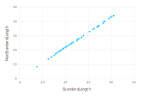

In [222]:
plot(perche, x=:StandardLength, y=:NonStandardLength)

## c) Sélection d'un sous-ensemble des variables explicatives 

Sélectionnez un sous-ensemble des variables explicatives pour lequel il n'y a pas de multicolinéarité.

Toutes les variables explicatives sont toutes liées linéairement entre elles. Pour éviter la multicolinéarité, il faut choisir une seule variable.

## c)  Identification du meilleur modèle de régression linéaire simple

Puisqu'il y a présence de multicolinéarité entre toutes les variables, on cherche le meilleur modèle unidimensionnel. Utilisez le critère de votre choix pour l'identifier.

**Suggestion :** Vous pouvez transformer la variable d'intérêt pour trouver le meilleur modèle linéaire unidimensionnel.

## d) Vérification des hypothèses de la régression

Vérifiez si les hypothèses 1 à 4 de la régression sont satisfaites. Pour ce faire, tracer les graphiques suivants :
- le nuage des points {(ŷᵢ, eᵢ) : 1 ≤ i ≤ n} pour vérifier les hypothèses 1 et 2
- la droite de Henry pour vérifier l'hypothèse 4.

**Suggestion :** Vous pouvez utiliser la fonction `henryplot()` fournie pour tracer le diagramme quantile-quantile entre la loi normale et les résidus.


In [ ]:
function henryplot(y::Vector{<:Real})

    n = length(y)
    ysorted = sort(y)

    p = ( collect(1:n) .- .5 ) /n

    fd = fit(Normal,y)

    q = quantile.(fd,p)

    plot(x=ysorted, y=q, Geom.point,
    Guide.xlabel("Empirical quantiles"), Guide.ylabel("Estimated quantiles"),
    Theme(discrete_highlight_color=c->nothing),
    Geom.abline(color="red"))

end

## e) Relation pour les poids originaux

Tracez le nuage de points illustrant les poids originaux des perches (dans le cas où vous auriez fait une transformation) en fonction votre variable explicative ainsi que la relation obtenue.

**Suggestion :** Utilisez la fonction `layer()` pour superposer plusieurs couches sur un graphique.

# Exercice 4 : Recherche du meilleur modèle possible

Dans cet exercice, on cherche le meilleur modèle pour prédire le poids de perches. J'ai l'impression que les modèles suivants pourraient être pertinents :
- X = StandardLength * Width * Height (on suppose que le poisson est de la forme d'un prisme rectangulaire)
- X = StandardLength * Width^2 (on suppose que le poisson est un cylindre)
- etc.

C'est votre travail de créer de nouvelles variables explicatives à partir de celle que vous avez pour rechercher le meilleur modèle possible.